In [1]:
import argparse, os

import copy
import torch
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
from einops import rearrange
from pytorch_lightning import seed_everything
from torch.cuda.amp import autocast
from contextlib import nullcontext
import torch.nn.functional as F
import torchvision.transforms as transforms

from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler

In [2]:
feat_maps = []

def save_img_from_sample(model, samples_ddim, fname):
    x_samples_ddim = model.decode_first_stage(samples_ddim)
    x_samples_ddim = torch.clamp((x_samples_ddim + 1.0) / 2.0, min=0.0, max=1.0)
    x_samples_ddim = x_samples_ddim.cpu().permute(0, 2, 3, 1).numpy()
    x_image_torch = torch.from_numpy(x_samples_ddim).permute(0, 3, 1, 2)
    x_sample = 255. * rearrange(x_image_torch[0].cpu().numpy(), 'c h w -> h w c')
    img = Image.fromarray(x_sample.astype(np.uint8))
    img.save(fname)


def feat_merge(opt, cnt_feats, sty_feats, start_step=0):
    feat_maps = [{'config': {
                'gamma':opt.gamma,
                'T':opt.T,
                'timestep':_,
                }} for _ in range(50)]

    for i in range(len(feat_maps)):
        if i < (50 - start_step):
            continue
        cnt_feat = cnt_feats[i]
        sty_feat = sty_feats[i]
        ori_keys = sty_feat.keys()

        for ori_key in ori_keys:
            if ori_key[-1] == 'q':
                feat_maps[i][ori_key] = cnt_feat[ori_key]
            if ori_key[-1] == 'k' or ori_key[-1] == 'v':
                feat_maps[i][ori_key] = sty_feat[ori_key]
    return feat_maps


def load_img(path, gray=False):
    image = Image.open(path).convert("RGB")
    x, y = image.size
    print(f"Loaded input image of size ({x}, {y}) from {path}")
    h = w = 512
    image = transforms.CenterCrop(min(x,y))(image)
    image = image.resize((w, h), resample=Image.Resampling.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return image if gray else (2.*image - 1.)


def render_img(x):
    x = 255. * torch.clamp((x + 1.0) / 2.0, min=0.0, max=1.0)
    x = rearrange(x.to(torch.uint8), 'n c h w -> h (n w) c')
    return Image.fromarray(x.cpu().numpy())


def adain(cnt_feat, sty_feat):
    cnt_mean = cnt_feat.mean(dim=[0, 2, 3],keepdim=True)
    cnt_std = cnt_feat.std(dim=[0, 2, 3],keepdim=True)
    sty_mean = sty_feat.mean(dim=[0, 2, 3],keepdim=True)
    sty_std = sty_feat.std(dim=[0, 2, 3],keepdim=True)
    output = ((cnt_feat-cnt_mean)/cnt_std)*sty_std + sty_mean
    return output


def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    model.cuda()
    model.eval()
    return model

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('--cnt', default = './data/cnt')
parser.add_argument('--sty', default = './data/sty')
parser.add_argument('--ddim_inv_steps', type=int, default=50, help='DDIM eta')
parser.add_argument('--save_feat_steps', type=int, default=50, help='DDIM eta')
parser.add_argument('--start_step', type=int, default=49, help='DDIM eta')
parser.add_argument('--ddim_eta', type=float, default=0.0, help='DDIM eta')
parser.add_argument('--H', type=int, default=512, help='image height, in pixel space')
parser.add_argument('--W', type=int, default=512, help='image width, in pixel space')
parser.add_argument('--C', type=int, default=4, help='latent channels')
parser.add_argument('--f', type=int, default=8, help='downsampling factor')
parser.add_argument('--T', type=float, default=1.5, help='attention temperature scaling hyperparameter')
parser.add_argument('--gamma', type=float, default=0.75, help='query preservation hyperparameter')
parser.add_argument("--attn_layer", type=str, default='6,7,8,9,10,11', help='injection attention feature layers')
parser.add_argument('--model_config', type=str, default='models/ldm/stable-diffusion-v1/v1-inference.yaml', help='model config')
parser.add_argument('--precomputed', type=str, default='./precomputed_feats', help='save path for precomputed feature')
parser.add_argument('--ckpt', type=str, default='models/ldm/stable-diffusion-v1/model.ckpt', help='model checkpoint')
parser.add_argument('--precision', type=str, default='autocast', help='choices: ["full", "autocast"]')
parser.add_argument('--output_path', type=str, default='output')
parser.add_argument("--without_init_adain", action='store_true')
parser.add_argument("--without_attn_injection", action='store_true')
opt = parser.parse_args([
    '--cnt','data/cnt/00.png', 
    '--sty', 'data/cnt/00.png',
    '--model_config', 'models/ldm/stable-diffusion-v1/v1-inference.yaml',
    '--ckpt', 'models/ldm/stable-diffusion-v1/model.ckpt',
    '--output_path', 'output_single',
    ])

opt

Namespace(C=4, H=512, T=1.5, W=512, attn_layer='6,7,8,9,10,11', ckpt='models/ldm/stable-diffusion-v1/model.ckpt', cnt='data/cnt/00.png', ddim_eta=0.0, ddim_inv_steps=50, f=8, gamma=0.75, model_config='models/ldm/stable-diffusion-v1/v1-inference.yaml', output_path='output_single', precision='autocast', precomputed='./precomputed_feats', save_feat_steps=50, start_step=49, sty='data/cnt/00.png', without_attn_injection=False, without_init_adain=False)

In [4]:
feat_path_root = opt.precomputed

# seed = torch.initial_seed()
# opt.seed = seed

seed_everything(22)

output_path = opt.output_path
os.makedirs(output_path, exist_ok=True)
if len(feat_path_root) > 0:
    os.makedirs(feat_path_root, exist_ok=True)

Global seed set to 22


In [5]:
model_config = OmegaConf.load(f"{opt.model_config}")
model = load_model_from_config(model_config, f"{opt.ckpt}")

unet_model = model.model.diffusion_model

sampler = DDIMSampler(model)
sampler.make_schedule(ddim_num_steps=opt.save_feat_steps, ddim_eta=opt.ddim_eta, verbose=False) 

uc = model.get_learned_conditioning([""])

Loading model from models/ldm/stable-diffusion-v1/model.ckpt
Global Step: 470000
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Some weights of the model checkpoint at /sun/home_models/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.5.mlp.fc2.bias', 'vision_model.encoder.layers.6.layer_norm1.bias', 'vision_model.encoder.layers.19.self_attn.out_proj.bias', 'vision_model.encoder.layers.14.layer_norm1.bias', 'vision_model.encoder.layers.6.self_attn.q_proj.weight', 'vision_model.encoder.layers.17.layer_norm1.bias', 'vision_model.embeddings.position_ids', 'vision_model.encoder.layers.11.self_attn.v_proj.weight', 'vision_model.encoder.layers.10.self_attn.k_proj.weight', 'vision_model.encoder.layers.23.self_attn.v_proj.weight', 'vision_model.encoder.layers.23.self_attn.q_proj.weight', 'vision_model.encoder.layers.19.self_attn.v_proj.weight', 'vision_model.encoder.layers.10.layer_norm1.weight', 'vision_model.encoder.layers.7.self_attn.q_proj.bias', 'vision_model.encoder.layers.2.self_attn.q_proj.bias', 'vision_model.encoder.layers.11.self_attn.out_proj.bias', 'vision_

In [6]:
uc.shape, uc.dtype

(torch.Size([1, 77, 768]), torch.float32)

In [7]:
self_attn_output_block_indices = list(map(int, opt.attn_layer.split(',')))
ddim_inversion_steps = opt.ddim_inv_steps
save_feature_timesteps = ddim_steps = opt.save_feat_steps

time_range = np.flip(sampler.ddim_timesteps)
idx_time_dict = {}
time_idx_dict = {}
for i, t in enumerate(time_range):
    idx_time_dict[t] = i
    time_idx_dict[i] = t


global feat_maps
feat_maps = [{'config': { 'gamma':opt.gamma, 'T':opt.T }} for _ in range(50)]

In [ ]:
idx_time_dict, time_idx_dict

In [ ]:
sampler.ddim_timesteps

In [ ]:
ddim_inversion_steps

In [8]:
def ddim_sampler_callback(pred_x0, xt, i):
    save_feature_maps_callback(i)
    save_feature_map(xt, 'z_enc', i)

def save_feature_maps(blocks, i, feature_type="input_block"):
    block_idx = 0
    for block_idx, block in enumerate(blocks):
        if len(block) > 1 and "SpatialTransformer" in str(type(block[1])):
            if block_idx in self_attn_output_block_indices:
                # self-attn
                q = block[1].transformer_blocks[0].attn1.q
                k = block[1].transformer_blocks[0].attn1.k
                v = block[1].transformer_blocks[0].attn1.v
                save_feature_map(q, f"{feature_type}_{block_idx}_self_attn_q", i)
                save_feature_map(k, f"{feature_type}_{block_idx}_self_attn_k", i)
                save_feature_map(v, f"{feature_type}_{block_idx}_self_attn_v", i)
        block_idx += 1

def save_feature_maps_callback(i):
    save_feature_maps(unet_model.output_blocks , i, "output_block")

def save_feature_map(feature_map, filename, time):
    global feat_maps
    cur_idx = idx_time_dict[time]
    feat_maps[cur_idx][f"{filename}"] = feature_map

In [9]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
start_step = opt.start_step
precision_scope = autocast if opt.precision=="autocast" else nullcontext
shape = [opt.C, opt.H // opt.f, opt.W // opt.f]
# sty_img_list = sorted(os.listdir(opt.sty))
# cnt_img_list = sorted(os.listdir(opt.cnt))
cnt_img = opt.cnt
cnt_name = cnt_img

In [10]:
x = load_img('data/ihs256/HAdobe5k/composite_images/a0002_1_4.jpg')
mask = load_img('data/ihs256/HAdobe5k/masks/a0002_1.png', gray=True)
mask = mask[:,0:1]

Loaded input image of size (256, 256) from data/ihs256/HAdobe5k/composite_images/a0002_1_4.jpg
Loaded input image of size (256, 256) from data/ihs256/HAdobe5k/masks/a0002_1.png


In [11]:
mask

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.]]]])

In [12]:

# for cnt_name in cnt_img_list:
# cnt_name_ = os.path.join(opt.cnt, cnt_name)
# init_cnt = load_img(cnt_img).to(device)
x = x.to(device)
init_cnt = x.clone()
mask = mask.to(device)
# ddim inversion encoding
res_first_stage = model.encode_first_stage(init_cnt)
init_cnt = model.get_first_stage_encoding(res_first_stage)
cnt_z_enc, _ = sampler.encode_ddim(
    init_cnt.clone(), 
    num_steps=ddim_inversion_steps,
    unconditional_conditioning=uc, 
    end_step=time_idx_dict[ddim_inversion_steps-1-start_step], 
    callback_ddim_timesteps=save_feature_timesteps,
    img_callback=ddim_sampler_callback)
cnt_feat = copy.deepcopy(feat_maps)
cnt_z_enc = feat_maps[0]['z_enc']

Running DDIM inversion with 50 timesteps


DDIM Inversion:   4%|▍         | 2/50 [00:00<00:04, 11.17it/s]

Selected timesteps for ddim sampler: [  1  21  41  61  81 101 121 141 161 181 201 221 241 261 281 301 321 341
 361 381 401 421 441 461 481 501 521 541 561 581 601 621 641 661 681 701
 721 741 761 781 801 821 841 861 881 901 921 941 961 981]


DDIM Inversion: 100%|██████████| 50/50 [00:04<00:00, 11.87it/s]


In [13]:
cnt_z_enc.shape

torch.Size([1, 4, 64, 64])

In [14]:
def adain_mask(x, mask):
    """
    """
    mask = F.interpolate(mask.detach(), size=x.size()[2:], mode='nearest')
    mean_back, std_back = get_foreground_mean_std(x * (1-mask), 1 - mask) # the background features
    mean_fore, std_fore = get_foreground_mean_std(x * mask, mask) # the background features
    normalized = ((x - mean_fore) / std_fore) * std_back + mean_back
    return x * (1-mask) + normalized * mask

def get_foreground_mean_std(region, mask):
    eps = 1e-5
    sum = torch.sum(region, dim=[2, 3])     # (B, C)
    num = torch.sum(mask, dim=[2, 3])       # (B, C)
    mu = sum / (num + eps)
    mean = mu[:, :, None, None]
    var = torch.sum((region + (1 - mask)*mean - mean) ** 2, dim=[2, 3]) / (num + eps)
    var = var[:, :, None, None]
    return mean, torch.sqrt(var+eps)

In [15]:
o1 = adain_mask(x, mask)
os = torch.cat((x, o1), dim=2)
img1 = render_img(os)

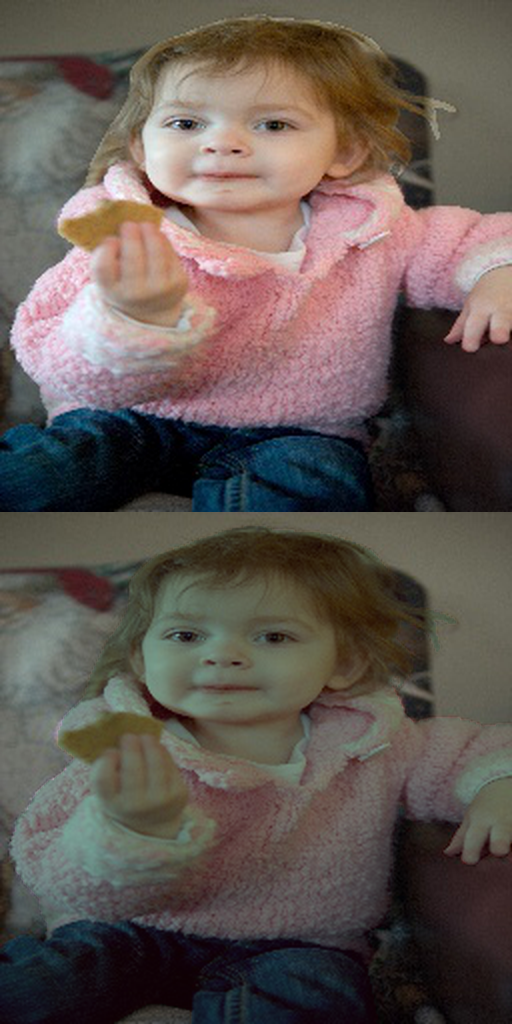

In [16]:
img1

In [17]:
def feat_merge(opt, cnt_feats, mask, start_step=0):
    feat_maps = [{'config': {
                'gamma':opt.gamma,
                'T':opt.T,
                'timestep':_,
                }} for _ in range(50)]

    for i in range(len(feat_maps)):
        if i < (50 - start_step):
            continue
        cnt_feat = cnt_feats[i]
        sty_feat = sty_feats[i]
        ori_keys = sty_feat.keys()

        for ori_key in ori_keys:   
            if ori_key[-1] == 'q':
                feat_maps[i][ori_key] = cnt_feat[ori_key]
            if ori_key[-1] == 'k' or ori_key[-1] == 'v':
                feat_maps[i][ori_key] = sty_feat[ori_key]
    return feat_maps

In [ ]:
# feat_maps

In [ ]:
len(feat_maps)

In [ ]:
feat_maps[0].keys()

In [ ]:
feat_maps[0]['output_block_11_self_attn_q'].shape

In [ ]:
feat_maps[0]['output_block_10_self_attn_k'].shape

In [ ]:
feat_maps[0]['output_block_7_self_attn_v'].shape

Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler:   0%|          | 0/50 [00:00<?, ?it/s]

DDIM Sampler: 100%|██████████| 50/50 [00:03<00:00, 14.61it/s]


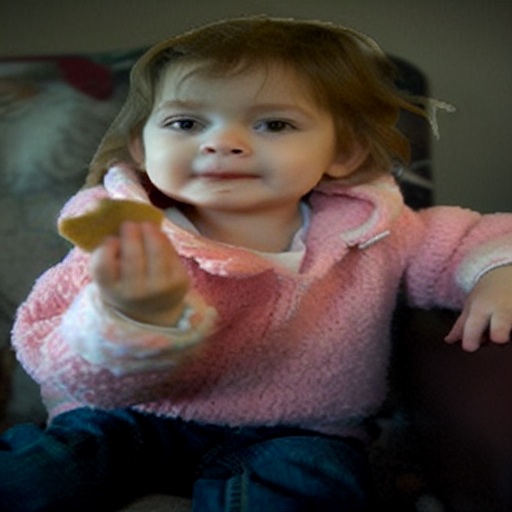

In [19]:
with torch.no_grad():
    with precision_scope(True):
        with model.ema_scope():
            # inversion
            # adain_z_enc = cnt_z_enc
            adain_z_enc = adain_mask(cnt_z_enc, mask)
            # feat_maps = feat_merge(opt, cnt_feat, sty_feat, start_step=start_step)
            # inference
            samples_ddim, intermediates = sampler.sample(S=ddim_steps,
                                            batch_size=1,
                                            shape=shape,
                                            verbose=False,
                                            unconditional_conditioning=uc,
                                            eta=opt.ddim_eta,
                                            x_T=adain_z_enc,
                                            injected_features=feat_maps,
                                            start_step=start_step,
                                            )

            x_samples_ddim = model.decode_first_stage(samples_ddim)
            img = render_img(x_samples_ddim)

img

In [ ]:
img